## Create a polygon around the extent of the lidar study area  
Code adapted from David Shean's GM_analysis notebook

Load a reduced resolution overview for processing  
Assumes overviews have already been generated with `gdaladdo -r gauss`

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from astropy.time import Time
from datetime import datetime
import rasterio as rio
from rasterio import features
import rioxarray

In [2]:
%matplotlib inline

In [3]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [4]:
dnr_fn = './datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_combined_asp-adj_4326.tif'

In [6]:
# I only have one lidar file, so I pulled this code out of the for loop that was
# written by David Shean in his GrandMesa_analysis notebook.

dnr_feat_list = []
#ovr_scale = 8
dt_fieldnum = 4
src = rio.open(dnr_fn)
a = src.read(1, masked=True)
mask = np.ma.getmaskarray(a).astype(np.uint8) - 1
shapes = features.shapes(mask, mask=mask, transform=src.transform)
geom_list = list(shapes)
dt = os.path.splitext(os.path.split(dnr_fn)[-1])[0].split('_')[dt_fieldnum]
dnr_feat_list.extend([{'properties':{'fn':dnr_fn, 'date':'2018'}, 'geometry':i[0]} for i in geom_list])

In [17]:
#dnr_gdf = gpd.GeoDataFrame.from_features(dnr_feat_list, crs=src.crs)
dnr_gdf = gpd.GeoDataFrame.from_features(dnr_feat_list, crs=src.crs)

In [9]:
dnr_gdf.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
#remove tiny polygons, if using a crs with units in meters (not degrees)
area_thresh = 1e8
dnr_gdf = dnr_gdf.loc[dnr_gdf.area > area_thresh]

In [ ]:
# if the above area threshold isn't big enough (or doesn't work because of the crs)
dnr_gdf = dnr_gdf.drop([0,1,2])

<AxesSubplot:>

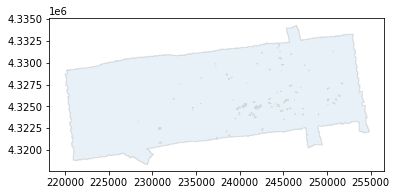

In [19]:
dnr_gdf.plot(alpha=0.1, edgecolor='k', legend=True)

In [21]:
dnr_gdf['date'] = pd.to_datetime(dnr_gdf['date'])
add_dowy(dnr_gdf, col='date')
dnr_gdf['platform'] = 'WaDNR'
dnr_gdf['acqdate'] = dnr_gdf['date']
dnr_gdf.set_index('date', inplace=True)

Adding Day of Water Year (DOWY)


In [22]:
dnr_gdf.to_file('../../data/gm_outline.geojson', driver='GeoJSON')